# Run this to install all the necessary libraries

In [ ]:
# !pip install -r requirements.txt

## Importing Libraries

In [52]:
# for os operations
import os

# for datetime functionalities
import datetime

# for image manipulation
import cv2

# for matrix operations
import numpy as np

# for dataframes
import pandas as pd

# for random number generation
import secrets

# for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns

# for machine learning utilities
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

# for deep learning stuffs
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

print(tf.__version__)

2.10.1


**Hyperparameters which can be tuned**

In [50]:

BATCH_SIZE = 8 #16
EPOCHS = 5
IM_SIZE_W = 150 #300
IM_SIZE_H = 200 #400

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(10)

**setting up GPU if available**

In [ ]:
 
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

In [ ]:
for dirname, _, filenames in os.walk('C:/sharath/archive (1)/Curated X-Ray Dataset'):
    print(dirname)

In [ ]:
filenames = tf.io.gfile.glob('C:/sharath/archive (1)/Curated X-Ray Dataset/*/*')
print(len(filenames))
filenames[:3]


**storing file path into dataframe**

In [ ]:
data = pd.DataFrame()
for el in range(0, len(filenames)):
    target = filenames[el].split('\\')[-2]
    path = filenames[el]
    
    data.loc[el, 'filename'] = path
    data.loc[el, 'class'] = target

print(data['class'].value_counts(dropna=False))
data

In [ ]:
data = shuffle(data, random_state=42)
data.reset_index(drop=True, inplace=True)
data

In [ ]:
change = {
'Normal' : '0',
'Pneumonia-Bacterial': '1',
'Pneumonia-Viral' : '2',
'COVID-19' : '3',
}

data['class'] = data['class'].map(change)
data

In [ ]:
indexes=[]

def func(x):
    if x[-4:] != '.jpg':
        idx = data[data['filename'] == x].index
        indexes.append(idx[0])
        print(idx[0], x)
    return x

data['filename'].map(func)

print(data.shape)
data.drop(index=indexes, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)

**Splitting the given dataset into train val then train test**

In [ ]:
train_data, val_data = train_test_split(data, test_size=0.1, random_state=42, stratify=data['class'])
print(train_data['class'].value_counts(dropna=False))
print(val_data['class'].value_counts(dropna=False))

In [ ]:
train_data, test_data = train_test_split(train_data, test_size=0.1, random_state=42, stratify=train_data['class'])
print(train_data['class'].value_counts(dropna=False))
print(test_data['class'].value_counts(dropna=False))

**setting up image data generation**

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, # 0.05
                             brightness_range=[0.9, 1.0],
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=10, 
                            )


test_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = datagen.flow_from_dataframe(train_data,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True,
                                        num_parallel_calls=AUTOTUNE)

val_gen = test_datagen.flow_from_dataframe(val_data,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)

test_gen = test_datagen.flow_from_dataframe(test_data,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)

## Vanilla CNN

**Model Building**

In [4]:
# # Define CNN model
# def create_model():
#     with tf.device('/gpu:0'):        
    
#         # Model input
#         input_layer = layers.Input(shape=(IM_SIZE_W, IM_SIZE_H, 1), name='input')  
        
#         # First block
#         x = layers.Conv2D(filters=128, kernel_size=3, 
#                           activation='relu', padding='same', 
#                           name='conv2d_1')(input_layer)
#         x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)
#         x = layers.Dropout(0.1, name='dropout_1')(x)

#         # Second block
#         x = layers.Conv2D(filters=128, kernel_size=3, 
#                           activation='relu', padding='same', 
#                           name='conv2d_2')(x)
#         x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)
#         x = layers.Dropout(0.1, name='dropout_2')(x)

#         # Third block
#         x = layers.Conv2D(filters=128, kernel_size=3, 
#                           activation='relu', padding='same', 
#                           name='conv2d_3')(x)
#         x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)
#         x = layers.Dropout(0.1, name='dropout_3')(x)

#         # Fourth block
#         x = layers.Conv2D(filters=256, kernel_size=3, 
#                           activation='relu', padding='same', 
#                           name='conv2d_4')(x)
#         x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)
#         x = layers.Dropout(0.1, name='dropout_4')(x)

#         # Fifth block
#         x = layers.Conv2D(filters=256, kernel_size=3, 
#                           activation='relu', padding='same', 
#                           name='conv2d_5')(x)
#         x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)
#         x = layers.Dropout(0.1, name='dropout_5')(x)

#         # Sixth block
#         x = layers.Conv2D(filters=512, kernel_size=3, 
#                           activation='relu', padding='same', 
#                           name='conv2d_6')(x)
#         x = layers.MaxPool2D(pool_size=2, name='maxpool2d_6')(x)
#         x = layers.Dropout(0.1, name='dropout_6')(x)

#         # Seventh block
#         x = layers.Conv2D(filters=512, kernel_size=3, 
#                           activation='relu', padding='same', 
#                           name='conv2d_7')(x)
#         x = layers.MaxPool2D(pool_size=2, name='maxpool2d_7')(x)
#         x = layers.Dropout(0.1, name='dropout_7')(x)
        
#         # GlobalAveragePooling
#         x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)   
#         x = layers.Flatten()(x)
        
#         # Head
#         x = layers.Dense(1024,activation='relu')(x)
#         x = layers.Dropout(0.1, name='dropout_head_2')(x)
#         x = layers.Dense(128,activation='relu')(x)
        
#         # Output
#         output = layers.Dense(units=4, 
#                               activation='softmax', 
#                               name='output')(x)


#         model = Model(input_layer, output)
    
        
        

#         F_1_macro = tfa.metrics.f_scores.F1Score(num_classes=4, average="macro", name='f1_macro') 
        
#         model.compile(optimizer='adam', 
#                       loss='categorical_crossentropy', 
#                       metrics=[F_1_macro, 'accuracy'])

#     return model

# model = create_model()

**Model fitting**

In [ ]:
# init_time = datetime.datetime.now()


# train_steps = train_gen.samples // BATCH_SIZE
# valid_steps = val_gen.samples // BATCH_SIZE

# early_stopping = EarlyStopping(monitor="val_loss", patience=8, mode="min")
# checkpoint = ModelCheckpoint("loss-{val_loss:.4f}.h5", monitor="val_loss", verbose=0, 
#                              save_best_only=True, save_weights_only=True, mode="min")
# learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4, 
#                                             min_lr=1e-7, verbose=1, mode="min")


# history = model.fit(
#     train_gen,
#     validation_data=val_gen,
#     batch_size=BATCH_SIZE,
#     epochs=EPOCHS,
#     steps_per_epoch=train_steps,
#     validation_steps=valid_steps,
#     callbacks=[
#                 checkpoint, 
#                 early_stopping, 
#                 learning_rate_reduction],
#     verbose=1,
#     )

# required_time = datetime.datetime.now() - init_time
# print(f'\nRequired time:  {str(required_time)}\n')

**Plotting history**

In [ ]:
# history_df = pd.DataFrame(history.history)
# history_df.loc[0:, ['loss', 'val_loss']].plot()
# print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [ ]:
# test_steps = test_gen.samples // BATCH_SIZE

# test_loss, test_f1macro, test_acc = model.evaluate(test_gen, steps=test_steps)
# print('\naccuracy:', test_acc, 'loss: ',test_loss, 'f1: ',test_f1macro)

In [ ]:
# predict = model.predict(test_gen, steps=test_steps)
# y_hat = np.argmax(predict, axis=1)
# y_hat[:20]

In [ ]:
# test_labels_df = pd.DataFrame()
# test_labels_df[['class']] = test_data[['class']]

# change = {
# '0' : 0,
# '1' : 1,
# '2' : 2,
# '3' : 3,
# }

# test_labels_df['class'] = test_labels_df['class'].map(change)
# test_labels_df = test_labels_df[ : test_steps*BATCH_SIZE]


# y_test = np.array(test_labels_df['class'])
# y_test[:20]

**Classification report and Confusion Matrix**

In [ ]:
# print(classification_report(y_test, y_hat), '\n')
# cm = confusion_matrix(y_test, y_hat)
# sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)

**Plotting Images**

In [ ]:
# iterator = iter(test_gen)
# imgs,labs = iterator.next()
# real_labs = list(np.argmax(labs, axis=1))
# print(real_labs)

In [ ]:
# class_dict = {
# 0 : 'Normal',
# 1 : 'Pneumonia-Bacterial',
# 2 : 'Pneumonia-Viral',
# 3 : 'COVID-19',
# }


In [ ]:
# plt.rcParams['font.size'] = '10'
# plt.subplots(BATCH_SIZE,1,figsize=(20,20))

# idx=1
# for i,img in enumerate(imgs[:BATCH_SIZE]):
#     img_4d = tf.cast(tf.reshape(img, [1, IM_SIZE_W, IM_SIZE_H, 1]), tf.float32)
#     predict = model.predict(img_4d)
#     prd = np.argmax(predict)
#     original_lab = real_labs[i]
    
#     plt.subplot(BATCH_SIZE,1,idx)
    
#     plt.imshow(img, cmap=plt.cm.binary)
    
#     proba = round(float(predict[0][prd]), 4)
#     plt.title(f'predicted as {class_dict[prd]} with {proba*100:.2f}% probability, the original class is {class_dict[original_lab]}')
#     plt.axis('off')
#     idx+=1
#     if idx>BATCH_SIZE*2:
#         break

# plt.tight_layout()
# plt.show()

## RESNET50

**Model Building**

In [53]:
# def resnet_model():
#     with tf.device('/gpu:0'):
#         img_input = tf.keras.layers.Input(shape=(IM_SIZE_H,IM_SIZE_W, 1))
#         img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])    
#         resnet_model = ResNet50(include_top=False, weights='imagenet', input_tensor=img_conc)
       
#         for layer in resnet_model.layers[:-1]:
#             layer.trainable = False
        
#         x = resnet_model.output
#         x = layers.Conv2D(filters=512, kernel_size=3, 
#                           activation='relu', padding='same', 
#                           name='conv2d_6')(x)
#         x = layers.MaxPool2D(pool_size=2, name='maxpool2d_6')(x)
#         x = layers.Dropout(0.1, name='dropout_6')(x)

#         # Seventh block
#         x = layers.Conv2D(filters=512, kernel_size=3, 
#                           activation='relu', padding='same', 
#                           name='conv2d_7')(x)
#         x = layers.MaxPool2D(pool_size=2, name='maxpool2d_7')(x)
#         x = layers.Dropout(0.1, name='dropout_7')(x)
        
#         # GlobalAveragePooling
#         x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)   
#         x = layers.Flatten()(x)
#         x = layers.Dense(1024,activation='relu')(x)
#         x = layers.Dropout(0.1, name='dropout_head_2')(x)
#         x = layers.Dense(128,activation='relu')(x)
        
#         # Output
#         output = layers.Dense(units=4, 
#                               activation='softmax', 
#                               name='output')(x)


#         model = Model(resnet_model.input, output)




#         F_1_macro = tfa.metrics.f_scores.F1Score(num_classes=4, average="macro", name='f1_macro') 

#         model.compile(optimizer='adam', 
#                       loss='categorical_crossentropy', 
#                       metrics=[F_1_macro, 'accuracy'])
#         return model

# model1 = resnet_model()

In [ ]:
# def vgg16_model():
#     with tf.device('/gpu:0'):
#         img_input = tf.keras.layers.Input(shape=(IM_SIZE_H,IM_SIZE_W, 1))
#         img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])    

#         vgg_model = VGG16(include_top=False, weights='imagenet', input_tensor=img_conc)
#         # resnet_model = ResNet50(input_shape = (IM_SIZE_H,IM_SIZE_W, 3), include_top = False, weights = 'imagenet')
#         # resnet_model.trainable = False
#         for layer in vgg_model.layers[:-1]:
#             layer.trainable = False
        
#         x = vgg_model.output
#         x = layers.Conv2D(filters=512, kernel_size=3, 
#                           activation='relu', padding='same', 
#                           name='conv2d_6')(x)
#         x = layers.MaxPool2D(pool_size=2, name='maxpool2d_6')(x)
#         x = layers.Dropout(0.1, name='dropout_6')(x)

#         # Seventh block
#         x = layers.Conv2D(filters=512, kernel_size=3, 
#                           activation='relu', padding='same', 
#                           name='conv2d_7')(x)
#         x = layers.MaxPool2D(pool_size=2, name='maxpool2d_7')(x)
#         x = layers.Dropout(0.1, name='dropout_7')(x)
        
#         # GlobalAveragePooling
#         x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)   
#         x = layers.Flatten()(x)
#         x = layers.Dense(1024,activation='relu')(x)
#         x = layers.Dropout(0.1, name='dropout_head_2')(x)
#         x = layers.Dense(128,activation='relu')(x)
        
#         # Output
#         output = layers.Dense(units=4, 
#                               activation='softmax', 
#                               name='output')(x)


#         model = Model(vgg_model.input, output)




#         F_1_macro = tfa.metrics.f_scores.F1Score(num_classes=4, average="macro", name='f1_macro') 

#         model.compile(optimizer='adam', 
#                       loss='categorical_crossentropy', 
#                       metrics=[F_1_macro, 'accuracy'])
#         return model

# model2 = vgg16_model()

In [ ]:
# init_time2 = datetime.datetime.now()


# train_steps = train_gen.samples // BATCH_SIZE
# valid_steps = val_gen.samples // BATCH_SIZE

# early_stopping = EarlyStopping(monitor="val_loss", patience=8, mode="min")
# checkpoint = ModelCheckpoint("vgg-loss-{val_loss:.4f}.h5", monitor="val_loss", verbose=0, 
#                              save_best_only=True, save_weights_only=True, mode="min")
# learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4, 
#                                             min_lr=1e-7, verbose=1, mode="min")


# history2 = model2.fit(
#     train_gen,
#     validation_data=val_gen,
#     batch_size=BATCH_SIZE,
#     epochs=EPOCHS,
#     steps_per_epoch=train_steps,
#     validation_steps=valid_steps,
#     callbacks=[
#                 checkpoint, 
#                 early_stopping, 
#                 learning_rate_reduction],
#     verbose=1,
#     )

# requared_time2 = datetime.datetime.now() - init_time2
# print(f'\nRequired time:  {str(requared_time2)}\n')

## Inference on new images

In [5]:
best_model = 'loss-0.4436.h5'

In [6]:
model.load_weights(best_model)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 150, 200, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 200, 128)     1280      
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 75, 100, 128)      0         
                                                                 
 dropout_1 (Dropout)         (None, 75, 100, 128)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 100, 128)      147584    
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 37, 50, 128)       0         
                                                                 
 dropout_2 (Dropout)         (None, 37, 50, 128)       0     

In [38]:
img = 'Curated X-Ray Dataset/COVID-19/COVID-19 (1002).jpg'


In [9]:
df = pd.DataFrame()
df['filename'] = [img]
df['class'] = ['COVID-19']

In [10]:
df

,filename,class
0,Curated X-Ray Dataset/COVID-19/COVID-19 (1002)...,COVID-19


In [11]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_gen = test_datagen.flow_from_dataframe(df,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)

Found 1 validated image filenames belonging to 1 classes.


In [12]:
# img_4d = tf.cast(tf.reshape(img, [1, IM_SIZE_W, IM_SIZE_H, 1]), tf.float32)
predict = model.predict(test_gen)

1/1 [==============================] - 5s 5s/step


In [33]:
predict

array([[0.27454478, 0.01080752, 0.00998597, 0.7046618 ]], dtype=float32)

In [13]:
y_hat = np.argmax(predict, axis=1)

In [14]:
y_hat

array([3], dtype=int64)

In [16]:
prd = np.argmax(predict)

In [44]:
class_dict = {
0 : 'Normal',
1 : 'Pneumonia-Bacterial',
2 : 'Pneumonia-Viral',
3 : 'COVID-19',
}


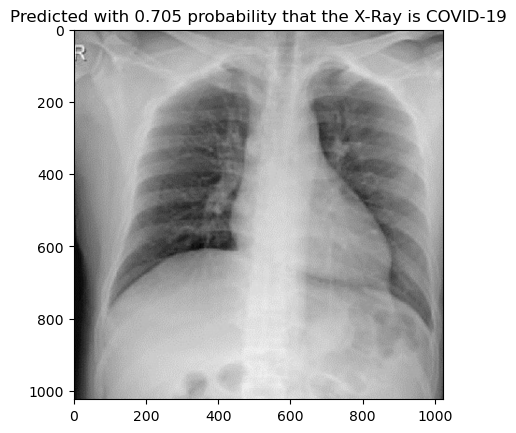

In [49]:
lab = np.max(predict)
img1 = cv2.imread(img)
plt.title(f'Predicted with {lab:.3f} probability that the X-Ray is {class_dict[prd]}')
plt.imshow(img1)

In [56]:
def predict_output(img):
    classes = ['Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral', 'COVID-19']
    df = pd.DataFrame()
    df['filename'] = [img]
    df['class'] = [secrets.choice(classes)]
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_gen = test_datagen.flow_from_dataframe(df,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)
    return test_gen
    

def predict_probability(img):
    test_gen = predict_output(img)
    predict = model.predict(test_gen)
    y_hat = np.argmax(predict, axis=1)
    class_dict = {
        0 : 'Normal',
        1 : 'Pneumonia-Bacterial',
        2 : 'Pneumonia-Viral',
        3 : 'COVID-19',
    }
    lab = np.max(predict)
    img1 = cv2.imread(img)
    img1 = cv2.resize(img1, (IM_SIZE_W, IM_SIZE_H))
    plt.title(f'Predicted with {lab:.3f} probability that the X-Ray is {class_dict[prd]}')
    plt.imshow(img1);

    

Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 259ms/step


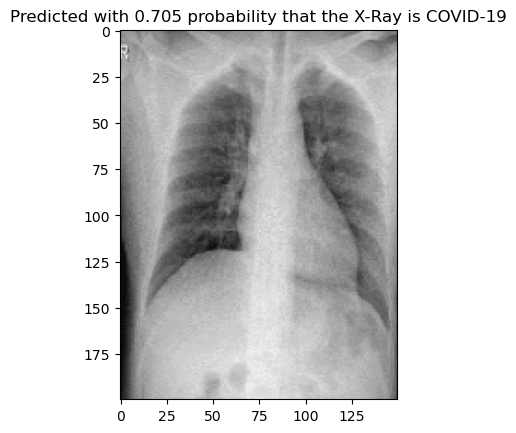

In [57]:
img = 'Curated X-Ray Dataset/COVID-19/COVID-19 (1002).jpg'
predict_probability(img)

## Conclusion

To conclude
- The accuracy/ f1-score for Vanilla CNN was 83% 
- The accuracy/ f1-score for Vanilla VGG16 was 80% 
- The accuracy/ f1-score for Vanilla Resnet50 was 74% 
- The vanilla CNN performed better than VGG16 and Resnet50 for Batch Size of 8 with Image width of 150 px, Image Height of 200px and Epochs of 5
- Further improvements can be made using different hyperparameters such as changing the above metrics

**By confusion matrix we can say that covid and pneumonia X-Rays are different**

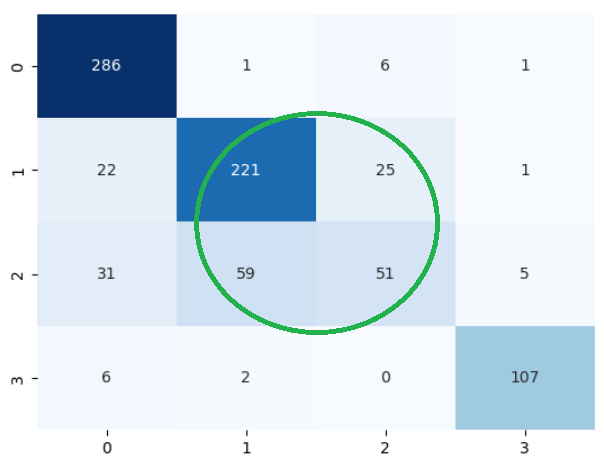
